In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

Functions:


In [ ]:
def normal_size(fpath, size=(50,50)):
    """
    Resize an image to the given size and normalize pixel intensity to [0, 1]. Use for smaller datasets/testing.
    """
    img = cv2.imread(fpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    img = img / 255.0
    return img


def split(labels):
    """
    Split the dataset into training and validation sets.
    """
    train_img, val_img = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels['label'])
    return train_img, val_img


def cvt_to_dataset(df, batch_size=32, img_size=(50, 50), labelled=True, cache_path=None):
    """
    Convert a DataFrame to a TensorFlow dataset. Implement caching at a later stage for performance improvement.
    """
    file_path = df['file_path'].values
    label = df['label'].values if labelled else None

    def handle_img(file_path): 
        """
        Read and preprocess a TIFF image file.
        """
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0

        return img.astype(np.float32)
    
    def load_and_reshape(file_path, label=None):
        """
        Returns image and label (if available) in the correct shpae ready to be converted to dataset.
        """
        img = tf.numpy_function(handle_img, [file_path], tf.float32)
        img.set_shape((*img_size, 3))

        if labelled:
            return img, label
        else:
            return img

    if labelled:
        dataset = tf.data.Dataset.from_tensor_slices((file_path, label))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(file_path)
    
    dataset = dataset.map(load_and_reshape, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache(cache_path) if cache_path else dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

def augment_data(dataset):
    """
    Apply data aumentation to images to improve model by increasing training dataset diversity and size.
    """


Linking images to labels

In [13]:
labels = pd.read_csv("../data/raw/histopathologic-cancer-detection/train_labels.csv")
labels['file_path'] = "../data/raw/histopathologic-cancer-detection/train/" + labels['id'] + ".tif"
pd.set_option('display.max_colwidth', None)
labels.head()


,id,label,file_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/raw/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/raw/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/raw/histopathologic-cancer-detection/train/755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/raw/histopathologic-cancer-detection/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/raw/histopathologic-cancer-detection/train/068aba587a4950175d04c680d38943fd488d6a9d.tif


Checking images load correctly

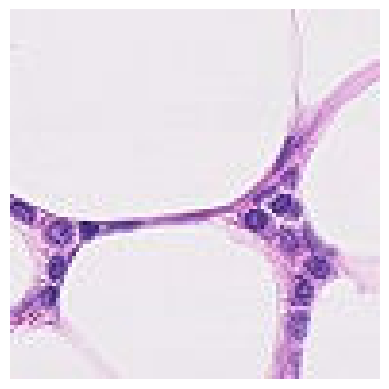

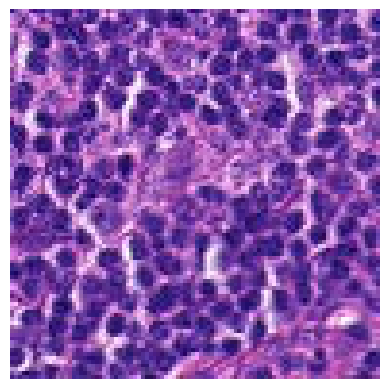

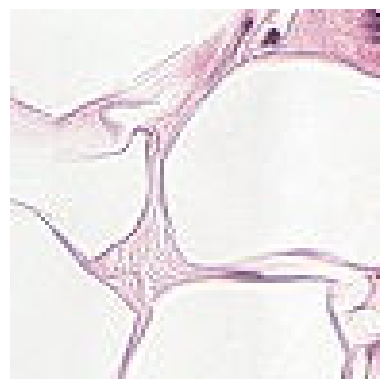

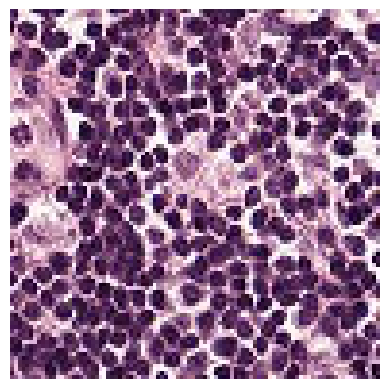

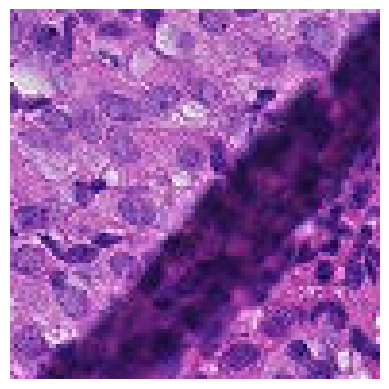

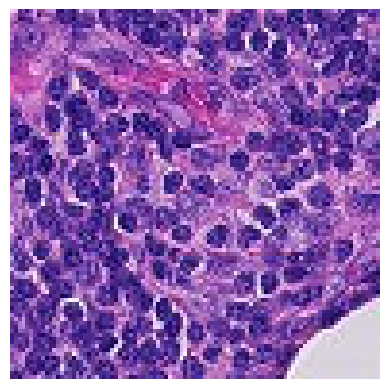

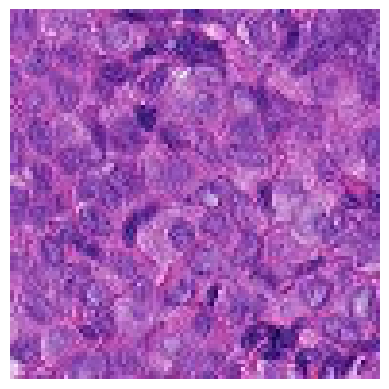

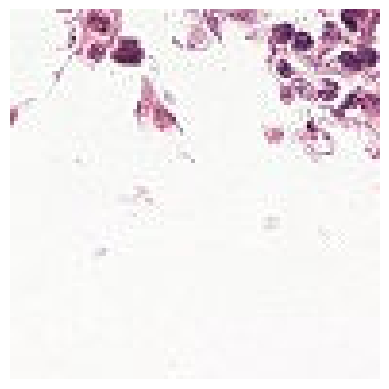

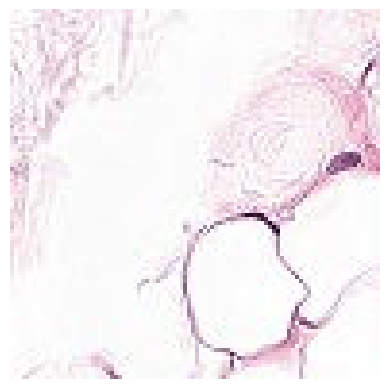

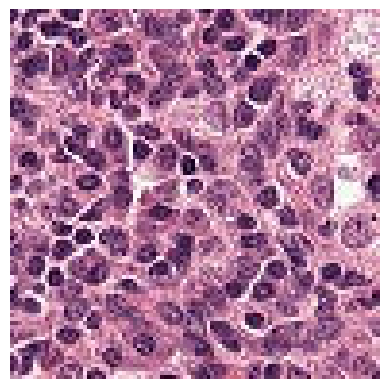

In [11]:
check = labels.sample(10, random_state=17)
for i, row in check.iterrows():
    img = cv2.imread(row["file_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Train test splitting

In [ ]:
train_img, val_img = split(labels)

['../data/raw/histopathologic-cancer-detection/test/00006537328c33e284c973d7b39d340809f7271b.tif', '../data/raw/histopathologic-cancer-detection/test/0000ec92553fda4ce39889f9226ace43cae3364e.tif', '../data/raw/histopathologic-cancer-detection/test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif', '../data/raw/histopathologic-cancer-detection/test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif', '../data/raw/histopathologic-cancer-detection/test/000270442cc15af719583a8172c87cd2bd9c7746.tif']


Creating test dataframe, converting all dataframes to tf datasets, loading and preprocessing all images

In [ ]:
test_files = [os.path.join("../data/raw/histopathologic-cancer-detection/test/", f) for f in os.listdir("../data/raw/histopathologic-cancer-detection/test")]
test_df = pd.DataFrame(test_files, columns=['file_path'])

ds_train = cvt_to_dataset(train_img, labelled=True, cache_path="E:/tensorflow_caches/train_cache")
ds_val = cvt_to_dataset(val_img, labelled=True, cache_path="E:/tensorflow_caches/validation_cache")
ds_test = cvt_to_dataset(test_df, labelled=False)